# **Predicting Match Outcomes in League of Legends Based on Team Performance and Player Statistics**

**_Author:_** *Mohamed Aymaan Zahir*

<img src="./lol_worlds.jpg" alt="Lol Worlds Image" width="1000" height="600">
<i>Credit: Colin Young-Wolff/Riot Games</i>

## **Overview**

The goal of this notebook is to uncover trends in player performance and build a model to predict the outcome of _League of Legends_ matches. By doing so, I hope to provide players with valuable insights into key factors that can improve their win rate. Additionally, my findings may assist developers to better understand the dynamics of their player base and make data-driven decisions that will improve the overall game experience.

In this analysis, I will begin by cleaning and pre-processing a _League of Legends_ match dataset, after which I will perform an exploratory analysis on the data, visualizing some key trends. Finally, I will use a CatBoost Classifier to predict match outcomes using the data available.

## **Data Description**

_License:_ **_CC BY 4.0 (Creative Commons Attribution 4.0 International)_**. \
This license allows sharing, modification, and use of the dataset as long as proper attribution is given.

The data that will be used is the `League of Legends Match Dataset (2025)` by user Jacob Krasuski from Kaggle.com: https://www.kaggle.com/datasets/jakubkrasuski/league-of-legends-match-dataset-2025

This dataset consists of 40412 rows and 94 columns, with each row representing a unique player in a match and each column representing information about various aspects regarding the match and the player's performance within the match. All of the data was taken from matches on the Europe Nordic and East server in 2024 and 2025. The focus of this analysis will solely be on data relating to the Classic mode. Please refer to the [Github ReadMe](https://github.com/aymaan-kj/League-of-Legends-Match-Analysis) for more information about _League of Legends_ and its terminology.

A summary of the most notable columns are listed below:

1. Details about the match: game duration, game start time, mode (e.g., Classic), game version, map identifiers and outcome.
2. Information about the player: identifiers, account name, account level
3. Player performance indicators: number of eliminations, assists, deaths, gold earned, damage dealt, damage taken, etc.
4. Information about the champion used: champion name, role, stats
5. Player rank information: solo tier, solo rank division, number of solo rank wins and losses, as well as the same information for their flex rank.

## **Initial Assumptions and Predictions About the Data**

Before exploring and analysing the data, there are a handful of observations that I expect to see which I would like to record beforehand in order to acknowledge prior biases, compare them with the results and explain certain decisions about which aspects of the data I will be examining.

**Data Exploration and Analysis Assumptions:**
1. Players of higher ranks (Platinum tier and above) likely perform better, on average, than lower rank players. I expect to see a higher average number of elimimations, lower deaths, higher vision score and more gold earned for higher ranked players, in addition to other performance metrics.
2. Each position is assumed to have differing performance metrics, since each role is designed to play the game differently. For example, I would expect a support player to have more assists and lower eliminations, while ADC players have more eliminations.
3. For the game to be balanced, I expect a roughly uniform distribution of win rates among each of the five positions.

**Classifier Model Assumptions:**
1. Based on experience, I believe the amount of gold earned, number of eliminations and the rank of the player to be the features that are most important in determining whether a game will be won or not.

## **Exploratory Data Analysis**

### **Data Cleaning**

The first step in my data cleaning process is to import the relevant libraries I will be using and load in the dataset. Essentially all of the cleaning will be done using Pandas, while the visualizations will be made using Matplotlib and Seaborn, and the classifier model using the Catboost library.

In [15]:
# importing the relevant libraries

# cleaning libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# visualization libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from tabulate import tabulate

# for the classifier model
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier, Pool, cv 
from sklearn.model_selection import train_test_split
import shap

Next, I will display some of the rows of the data for future reference on how the data looks like. Additionally, as good practice I will keep an original copy of the data to ensure that the the raw data remains unmodified even though the unchanged raw data is still available on Kaggle.

In [17]:
# loading in the dataset

matches = pd.read_csv("league_data.csv", dtype={17: 'str'}, parse_dates=['game_start_utc']) # ensuring dates are parsed correctly

# keeping an original copy of the data
matches_og = matches.copy()

matches.head(5)

,game_id,game_start_utc,game_duration,game_mode,game_type,game_version,map_id,platform_id,queue_id,participant_id,...,final_magicPen,final_magicPenPercent,final_magicResist,final_movementSpeed,final_omnivamp,final_physicalVamp,final_power,final_powerMax,final_powerRegen,final_spellVamp
0,3.727443e+09,2025-01-15 14:56:00,1714.0,CLASSIC,MATCHED_GAME,15.1.649.4112,11.0,EUN1,420.0,5.0,...,0.0,0.0,48.0,385.0,0.0,0.0,799.0,1134.0,147.0,0.0
1,3.726377e+09,2025-01-13 10:50:00,1300.0,CLASSIC,MATCHED_GAME,15.1.648.3927,11.0,EUN1,420.0,5.0,...,0.0,0.0,38.0,390.0,0.0,0.0,970.0,970.0,105.0,0.0
2,3.729644e+09,2025-01-19 18:15:00,2019.0,CLASSIC,MATCHED_GAME,15.1.649.4112,11.0,EUN1,420.0,2.0,...,0.0,0.0,121.0,431.0,0.0,0.0,10000.0,10000.0,0.0,0.0
3,3.729916e+09,2025-01-20 01:27:00,1625.0,CLASSIC,MATCHED_GAME,15.1.649.4112,11.0,EUN1,420.0,8.0,...,12.0,0.0,47.0,380.0,0.0,0.0,1122.0,1596.0,37.0,0.0
4,3.729902e+09,2025-01-20 00:40:00,1542.0,CLASSIC,MATCHED_GAME,15.1.649.4112,11.0,EUN1,420.0,10.0,...,0.0,0.0,40.0,534.0,0.0,0.0,1025.0,1025.0,109.0,0.0


#### **1) Removing Unnecessary Columns**

There are many columns in the data that are either redundant (such as some of the role columns which repeat essentially to same information), missing most of their values when manually looking at the data (like the flex rank columns and some of the champion stat columns), or do not provide any useful information for the analysis or predictions (like some ID columns). As such, I will remove many of these columns, which will roughly halve the number of features available for us to use. This is not concerning given that this means we still have more than 40 columns of data to work with- more than enough for the scale of this analysis. The following code lists the columns that will be kept in the final dataset and subsequently removes all columns which are not listed.

In [20]:
# defining the columns that will be kept
filter_cols = ['game_id', 'game_start_utc', 'game_duration', 'game_mode', 'game_version', 'summoner_id',
               'summoner_level', 'champion_name', 'team_id', 'individual_position', 'kills', 'deaths', 
               'assists', 'gold_earned', 'gold_spent', 'total_damage_dealt', 'physical_damage_dealt_to_champions',
               'magic_damage_dealt_to_champions', 'true_damage_dealt_to_champions', 'damage_dealt_to_objectives', 
               'damage_dealt_to_turrets', 'physical_damage_taken', 'magic_damage_taken', 'true_damage_taken', 'time_ccing_others',
               'vision_score', 'wards_placed', 'wards_killed', 'solo_tier', 'solo_rank', 'solo_lp', 'solo_wins', 'solo_losses',
               'champion_mastery_level', 'champion_mastery_points', 'final_abilityPower', 'final_armor', 'final_attackDamage',
               'final_attackSpeed', 'final_healthMax', 'final_magicResist', 'final_movementSpeed', 'win']

# filtering the dataset for only the columns listed
matches_filtered = matches[filter_cols]
# renaming columns to be more appropriate
matches_filtered = matches_filtered.rename(columns={'kills': 'eliminations'})

matches_filtered.head()

,game_id,game_start_utc,game_duration,game_mode,game_version,summoner_id,summoner_level,champion_name,team_id,individual_position,...,champion_mastery_level,champion_mastery_points,final_abilityPower,final_armor,final_attackDamage,final_attackSpeed,final_healthMax,final_magicResist,final_movementSpeed,win
0,3.727443e+09,2025-01-15 14:56:00,1714.0,CLASSIC,15.1.649.4112,8w6pbOajcaSi7ASzTLsuCmg8jCpAVUJN3uxW2FUzUTE3x6g,2065.0,Nami,100.0,UTILITY,...,77.0,889610.0,155.0,97.0,91.0,131.0,2138.0,48.0,385.0,TRUE
1,3.726377e+09,2025-01-13 10:50:00,1300.0,CLASSIC,15.1.648.3927,8w6pbOajcaSi7ASzTLsuCmg8jCpAVUJN3uxW2FUzUTE3x6g,2064.0,Lulu,100.0,UTILITY,...,69.0,852655.0,117.0,59.0,64.0,115.0,1680.0,38.0,390.0,FALSE
2,3.729644e+09,2025-01-19 18:15:00,2019.0,CLASSIC,15.1.649.4112,CeGCyYCjlzI8yy-yLBJ20FOiO239D1m6M4F3XK6Y52RsgqI,1851.0,Viego,100.0,JUNGLE,...,148.0,1756910.0,0.0,125.0,275.0,204.0,2672.0,121.0,431.0,FALSE
3,3.729916e+09,2025-01-20 01:27:00,1625.0,CLASSIC,15.1.649.4112,gL-HcTa7QMJYprHrrqums9w7wVj5P7vYq9uITGlIRMaOv2Y,1796.0,Malzahar,200.0,MIDDLE,...,6.0,35230.0,233.0,105.0,94.0,126.0,2369.0,47.0,380.0,FALSE
4,3.729902e+09,2025-01-20 00:40:00,1542.0,CLASSIC,15.1.649.4112,gL-HcTa7QMJYprHrrqums9w7wVj5P7vYq9uITGlIRMaOv2Y,1796.0,Lulu,200.0,UTILITY,...,56.0,642297.0,66.0,63.0,67.0,117.0,1807.0,40.0,534.0,FALSE


#### **2) Checking Column Data Types**

Our next step is to ensure that each column has a suitable data type before we can modify their data.

In [23]:
# displaying column data types
matches_filtered.dtypes

game_id                                      float64
game_start_utc                        datetime64[ns]
game_duration                                float64
game_mode                                     object
game_version                                  object
summoner_id                                   object
summoner_level                               float64
champion_name                                 object
team_id                                      float64
individual_position                           object
eliminations                                 float64
deaths                                       float64
assists                                      float64
gold_earned                                  float64
gold_spent                                   float64
total_damage_dealt                           float64
physical_damage_dealt_to_champions           float64
magic_damage_dealt_to_champions              float64
true_damage_dealt_to_champions               f

All of the columns seem to have feasible data types so we can move on.

#### **3) Changing Naming Semantics**

Upon manually exploring the data, there were a few naming conventions used for certain column values that are typically uncommon. Although this would not significantly alter the results of the analysis, it is better to change them in case they appear in the output of some of the code

One odd naming convention that I noticed was the use of 'MonkeyKing' to refer to the character named 'Wukong'. Before I correct this, I would like to check first that there is enough data about each character, since this a column that I am particularly interested in for later analysis.

In [28]:
# counting number of rows for each champion
champions = matches.groupby("champion_name").size().reset_index(name="count")

# displaying in ascending order of count
champions.sort_values(by = "count")

,champion_name,count
67,Kled,40
48,Ivern,49
111,Rumble,67
104,Rammus,71
95,Olaf,72
...,...,...
53,Jhin,633
76,Lux,663
54,Jinx,678
82,MissFortune,713


Since the least played character still has a decent amount of data, and all characters are represented in the data given that the number of rows in the above dataframe matches the amount of playable characters available at the time that this data was collected, I am happy to move on to correcting the character name mentioned above.

In [30]:
# replacing values with correct name
matches_filtered.loc[:,'champion_name'] = matches_filtered['champion_name'].replace('MonkeyKing', 'Wukong')

A second unusual term that was used concerns the `individual_position` column. Judging from personal experience the group of champions that fall under the 'Support' position were listed as 'Utility'. Additionally, there should only be 5 unique values for this column, but there may be more so we will check this in the following code.

In [33]:
# display unique values for column
matches_filtered['individual_position'].unique()

array(['UTILITY', 'JUNGLE', 'MIDDLE', 'Invalid', 'BOTTOM', 'TOP', nan],
      dtype=object)

Like I mentioned, there is no 'Support' position in the list of values since 'Utility' is used instead, so we shall change this. Additionally, while 'Bottom' is technically valid, a more widely used name for the role is 'ADC' (short for Attack Damage Carry), so I will also change this.

In [35]:
# replacing value with correct name
matches_filtered.loc[:,'individual_position'] = matches_filtered['individual_position'].replace({'UTILITY': 'SUPPORT', 'BOTTOM': 'ADC'})

Another interesting observation is the 'Invalid' term among the values. I suspect this value may be taken for rows referring to the ARAM game mode so we will leave it for now and come back to it soon in a future section of the notebook.

#### **4) Filtering the Dataset For Only Classic Mode Data**

The three game modes in League of Legends differ quite significantly both in terms of how they play, and what data is available for them. For example, the game mode ARAM does not have set roles like the Classic Summoner's Rift mode and there are no jungle objectives, while the Swiftplay data is quite limited given that the mode is relatively not as popular. In order to analyse the data and make predictions for match outcomes, each game mode would need to be treated differently and cannot simply be grouped together. Since this analysis is focused on the Classic League of Legends mode, I shall only keep rows for this mode and filter out the rest.

In [46]:
# filtering game mode
sr = matches_filtered[matches_filtered['game_mode'] == 'CLASSIC']

#### **5) Dealing with Null Values**

We will now check the dataset for null values. When first looking at the data through manual exploration, I saw many null values for the Solo rank columns, but I expect that this is concentrated mostly around the ARAM mode rows, so there might not be as many missing values for this subset.

In [50]:
# counting null values per column
sr.isna().sum()

game_id                                  0
game_start_utc                           0
game_duration                            0
game_mode                                0
game_version                             0
summoner_id                              0
summoner_level                           0
champion_name                            0
team_id                                  0
individual_position                      0
eliminations                             0
deaths                                   0
assists                                  0
gold_earned                              0
gold_spent                               0
total_damage_dealt                       0
physical_damage_dealt_to_champions       0
magic_damage_dealt_to_champions          0
true_damage_dealt_to_champions           0
damage_dealt_to_objectives               0
damage_dealt_to_turrets                  0
physical_damage_taken                    0
magic_damage_taken                       0
true_damage

In [52]:
# checking number of rows and columns
sr.shape

(29400, 43)

Most of the rows in this subset have data in the Solo rank columns, which is promising, but some work still needs to be done to deal with the missing values. In order to preserve the rows with missing data, we will treat the players as if they are unranked, which is a very plausible assumption as not all players play the ranked version of the classic game mode.

The following describes how missing values in each `solo` column will be dealt with: 
1. For the `solo_tier` column, I will fill in the value "Unranked"
2. For `solo_rank`, I will put the roman numeral value "V", since "I" is the highest rank and "IV" is the lowest, and we need another symbol lower than that that has not been used
3.  For all of the rows in the other 3 columns, we will impute the value 0.

All other missing values in other columns will be dropped since there is a negligible amount.

In [55]:
# filling missing values with their respective imputed values
sr.loc[:,'solo_tier'] = sr['solo_tier'].fillna('UNRANKED')
sr.loc[:, 'solo_rank'] = sr['solo_rank'].fillna('V')
sr.loc[:, 'solo_lp'] = sr['solo_lp'].fillna(0)
sr.loc[:, 'solo_wins'] = sr['solo_wins'].fillna(0)
sr.loc[:, 'solo_losses'] = sr['solo_losses'].fillna(0)

# dropping the rest of the null values
sr = sr.dropna()

Lastly, let us also check for 'Invalid' position values in the data. In my earlier cleaning I observed many 'Invalid' value counts but as I mentioned I assume they are for the ARAM game mode. Since that mode is non-existent in this subset, I believe there will not be many rows with this value, if any at all.

In [58]:
# checking for rows with an invalid value for the position column
sr[sr['individual_position'] == 'Invalid'].shape[0]

16

Since there are barely any rows that do not have valid roles, we will simply drop these rows.

In [61]:
sr_clean = sr[sr['individual_position'] != 'Invalid']

I am now quite confident that the data is clean; we just need to do some feature engineering before we can start to calculate summary statistics and answer some questions about the data that will give us insights into some of the trends present.

#### **6) Feature Engineering**

The date column that is available contains a lot of information, but in order for it to be used in the model we need to seperate it into multiple columns for the year, month, day, hour and minute. We will also generate two other columns that denote which day of the week it is and whether or not the game was played on a weekend as this may provide useful information.

In [68]:
# splitting the date column into each level of time
sr_clean.loc[:, 'year'] = sr_clean.loc[:, 'game_start_utc'].dt.year
sr_clean.loc[:, 'month'] = sr_clean.loc[:, 'game_start_utc'].dt.month
sr_clean.loc[:, 'day'] = sr_clean.loc[:, 'game_start_utc'].dt.day
sr_clean.loc[:, 'hour'] = sr_clean.loc[:, 'game_start_utc'].dt.hour
sr_clean.loc[:, 'minute'] = sr_clean.loc[:, 'game_start_utc'].dt.minute

# obtaining which day of the week it is in terms of a number from 1 to 7
sr_clean.loc[:, 'day_of_week'] = sr_clean.loc[:, 'game_start_utc'].dt.dayofweek
# creating column that shows True if weekend or 0 otherwise using day of week
sr_clean.loc[:, 'is_weekend'] = (sr_clean.loc[:, 'day_of_week'] >= 5)

Now that we have created the new columns, we do not need the original date column, so it will be dropped

In [71]:
# dropping original date column
sr_clean = sr_clean.drop(columns = ['game_start_utc'])

Currently all of the date columns are integers, but for us to get information about cyclical trends it would be better for the date columns to be string columns while leaving the time columns numeric.

In [76]:
# defining columns to convert
date_str_cols = ['month', 'day_of_week', 'is_weekend', 'day']
# converting columns to strings
sr_clean.loc[:, date_str_cols] = sr_clean.loc[:, date_str_cols].astype(str)

Another two columns I would like to create are derived columns from some of the performance metrics in the data. The first one I want to calculate is the KDA (short for kills, deaths, assists) that adds together the player eliminations and assists and divides it by the number of deaths. The second one I want to calculate is the gold per minute. These will be useful to analyse as more broad and wholistic performance measures,

In [79]:
# adding elimination and assists columns and dividing by deaths
sr_clean.loc[:, 'kda'] = (sr_clean.loc[:,'eliminations'] + sr_clean.loc[:, 'assists'])/sr_clean.loc[:, 'deaths']
# dividing gold earned by the duration in minutes
sr_clean.loc[:,'gold/min'] = sr_clean.loc[:, 'gold_earned']/(sr_clean.loc[:, 'game_duration']/60)

One important observation about KDA is that it can be undefined if a player has 0 deaths. This means some of the values in this column will appear as null, inf or -inf, so we need to deal with these values appropriately. In the game, this type of KDA is known as a 'perfect KDA', but since we want to keep this column numeric, we will simply convert these values into a high number compared to the rest of the data to emphasise the value of a perfect KDA. The value that will be used is 100.

In [82]:
# convert null and inf values to 100
sr_clean.loc[:, 'kda'] = sr_clean.loc[:, 'kda'].fillna(100)
sr_clean.loc[:, 'kda'] = sr_clean.loc[:, 'kda'].replace([np.inf, -np.inf], 100)

Our data is now ready to be analysed!

### **Calculating Summary Statistics and Visualising the Data**

#### **a) Summary Statistics**

To begin, in order to obtain a broad idea of how the data is distributed I will calculate some summary statistics about the data. Due to the large amount of columns in the dataset, I will only focus on the columns I believe are the most important measures of skill or features of the match. The code below displays a table showing the spread and central tendancy of each of these columns.

In [88]:
# defining key columns
summ_columns = ['game_duration', 'summoner_level', 'eliminations', 'deaths', 'assists', 'gold_earned', 'total_damage_dealt',
                'time_ccing_others', 'vision_score']
# displaying summary table rounded to nearest whole number
round(sr_clean[summ_columns].describe(),0)

,game_duration,summoner_level,eliminations,deaths,assists,gold_earned,total_damage_dealt,time_ccing_others,vision_score
count,29376.0,29376.0,29376.0,29376.0,29376.0,29376.0,29376.0,29376.0,29376.0
mean,1706.0,412.0,6.0,6.0,8.0,11002.0,138919.0,27.0,25.0
std,456.0,261.0,5.0,3.0,6.0,3850.0,89486.0,25.0,21.0
min,101.0,7.0,0.0,0.0,0.0,500.0,0.0,0.0,0.0
25%,1481.0,211.0,2.0,4.0,4.0,8470.0,68804.0,11.0,12.0
50%,1721.0,383.0,5.0,6.0,7.0,10899.0,132120.0,22.0,18.0
75%,1970.0,570.0,9.0,8.0,11.0,13458.0,192576.0,37.0,28.0
max,3307.0,2065.0,39.0,28.0,47.0,29741.0,699786.0,366.0,193.0


From the above output we can make the following key observations:

1. The average game of League of Legends takes around 30 minutes. From personal experience this seems extremely reasonable and as expected.
2. The longest game in the dataset was only around 55 minutes. In my time playing the game there have been some matches that took longer than an hour to finish, but this was very rare. Given that this dataset is based on a limited timeframe and from only one region of data, this number does not seem unreasonable at all.
3. The summoner level of players varies quite a lot, with the lowest level being 7 and the highest being 2065! For context, I have played League of Legends consistently for almost 4 years and I have a summoner level of around 400, meaning the player with the highest level in the dataset has put a tremendous amount of time into the game.
4. Player eliminations, deaths and assists seem to move together relatively closely, with assists being slightly higher.
5. The difference between the average total damage dealt and the highest is quite large. I will look into this further to see which role and champion the highest value is associated with and where most of the damage was dealt.
6. The longest time crowd controlling others is a massive 366 seconds. Looking at the mean, most people only get a score around 30 but this deviation is extremely large. Like the previous point, I am interested to see more about the row of data associated with this value.

In [91]:
# obtaining the row with the highest total_damage_dealt
sr_clean.loc[sr_clean['total_damage_dealt'].idxmax()]

game_id                                                                    3729409538.0
game_duration                                                                    2309.0
game_mode                                                                       CLASSIC
game_version                                                              15.1.649.4112
summoner_id                           NRWOO6zzIGVwamFLyx4GHHITebuZ5JEVB5pw7zhJCKjzfJ...
summoner_level                                                                    187.0
champion_name                                                                     Diana
team_id                                                                           200.0
individual_position                                                              JUNGLE
eliminations                                                                       16.0
deaths                                                                              7.0
assists                         

Looking at this row, it makes sense how a player could achieve such a high damage dealt. The player was playing the role of a jungler, who is in charge of taking jungle objectives. Since total damage dealt does not differentiate between damage to players, objectives, minions, etc., this high value could be the result of the player focusing on jungle camps or objectives. Unfortunately, we don’t have specific data for some of these activities, other than objectives (which is quite high at 80000 damage), making it hard to pinpoint the exact source of the damage.

Let us also check the row having the longest crowd control score.

In [95]:
# obtaining the row with the highest time_ccing_others
sr_clean.loc[sr_clean['time_ccing_others'].idxmax()]

game_id                                                                  3726869030.0
game_duration                                                                  2643.0
game_mode                                                                     CLASSIC
game_version                                                            15.1.649.4112
summoner_id                           FzfdXnFP1uBXfTyPIq4O-hndH3zJX4zUS7TmU9GOfAU1xvY
summoner_level                                                                  393.0
champion_name                                                                Nocturne
team_id                                                                         200.0
individual_position                                                            JUNGLE
eliminations                                                                      6.0
deaths                                                                            7.0
assists                                               

The champion that is associated with this crowd control score is 'Nocturne', who has the ability to essentially make all enemy players 'blind' in the game for a few seconds. Given that this ability usually has a short cooldown and it affects all enemy players simultaneously for quite a long period, this crowd control value makes more sense.

#### **b) Correlation Between Features**

Another important aspect of the data I would like to inspect before making the predictive model is the correlation between key features in the data. This will give us insight into how some features move with each other. In order to avoid making a cluttered visualisation, I will once again only use the key features I defined when calculating the summary statistics.

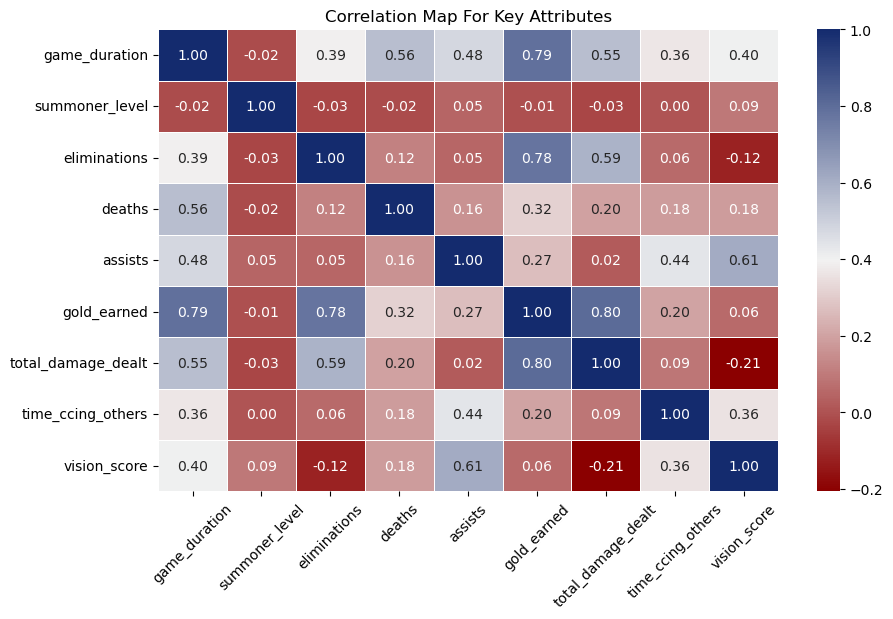

In [100]:
# calculate correlation coefficients between key columns
corr_matrix = sr_clean[summ_columns].corr()

# defining a colour scale that suits the theme of league of legends
league_cmap_colors = ["#8B0000", "#F2F2F2", "#142b6e"]
league_c_scale = LinearSegmentedColormap.from_list("league_c_scale", league_cmap_colors, N=256)

# plotting a correlation map
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap=league_c_scale, linewidths=0.5, fmt='.2f')
plt.xticks(rotation = 45) # rotate the xticks for visibility
plt.title('Correlation Map For Key Attributes') # adding a title

plt.show()

Based on the colours, there are only a few correlation coefficients that stick out. Two of the most positively correlated features, with a correlation coefficient of 0.79, are `gold_earned` and `game_duration`. This is understandable since the amount of gold you earn both passively and actively increases as the game goes on, never reducing, so more gold will naturally be earned in longer games.

Another highly positively correlated pair of features is `gold_earned` and `eliminations`. Similar to the previous relationship, each elimination a player gets gives them more gold, so a person with more elimations is associated with higher gold earned. Likewise, the most positively correlated features are `gold_earned` and `total_damage_dealt`. As mentioned before, the latter refers to any damage dealt in the game, whether it be to players, minions, objectives, etc., and since doing damage to something in the game is the only way to eliminate it and obtain gold, a player who has done a lot of damage is likely to have earned more gold. For example, a player who dealt a lot of damage to minions probably earned a lot of gold from them, or a player who dealt a lot of turret damage probably gained more gold from destroying turrets.

Another interesting relationship is the moderately high positive relationship between `vision_score` and `assists`. While out of context this does not make any sense, as placing or destroying wards does not directly contribute to assists and vice versa, when considering that the support role is in charge of placing and clearing wards while providing assistance to other players, it makes sense that when a player has a high vision score, they are likely a support player so in turn they probably have a high number of assists.

On the flip side, there does not appear to be any features with strong negative relationships. The largest negative association exists between `vision_score` and `total_damage_dealt`, but the magnitude is still weak at 0.21. Regardless, analysing why this relationship exists is similar to the previous point; high vision scores are normally obtained by support players, who normally do not do much damage since they mostly have healing, shielding or crowd control abilities, and they generally do not kill many minions.

#### **c) Distribution of Summoner Level**

When observing the summary statistics table from earlier I noticed a potentially right-skewed distribution, given that most values hovered around 400 while the highest was well over 2000. To test this, I will display a histogram to gain a clear picture of the distribution for this feature. 

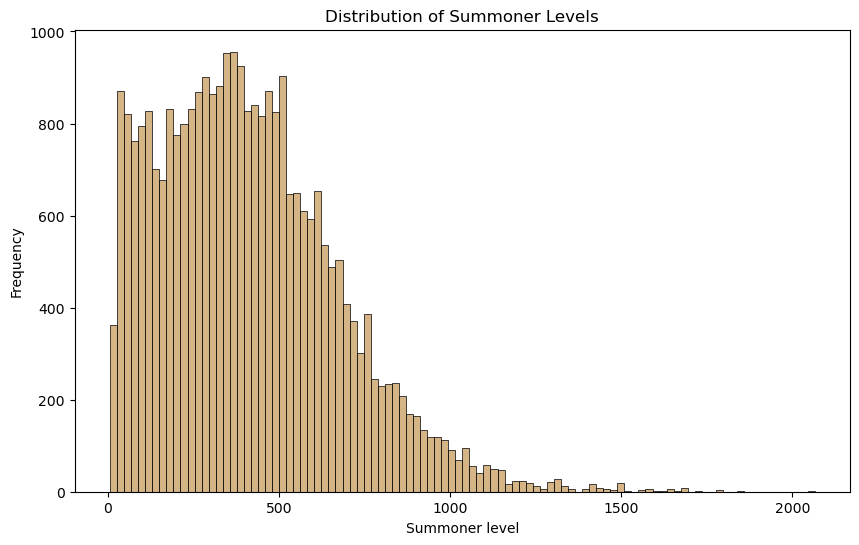

In [105]:
# plotting histogram for summoner level
plt.figure(figsize = (10,6))
sns.histplot(data = sr_clean, x = 'summoner_level', bins = 100, color = '#c89b5d')

# adding a title and axes labels
plt.title('Distribution of Summoner Levels')
plt.xlabel('Summoner level')
plt.ylabel('Frequency')

plt.show()

As I expected, most players have a summoner level in the 300 to 500 range, with a few over 1500 as indicated by the long right tail. I do not expect this to hinder our results, as summoner level is an indicator of how long a player has been playing and is potentially linked to a player's rank, so removing the high values may remove key information representing the small proportion of players at very high ranks in the dataset.

#### **d) Performance By Position Analysis**

When analysing League of Legends match data, it is important to recognize that each player on a team will have different statistics based on the role they are playing. As such, separating some performance indicators by roles will give us better insights into player performance and will also allow us to check if, on average, a player's performance does indeed vary based on role and whether or not some roles have an advantage when it comes to winning a game.

I will begin by checking the representation of each role in the dataset and the win probability by role using bar charts with the code block below.

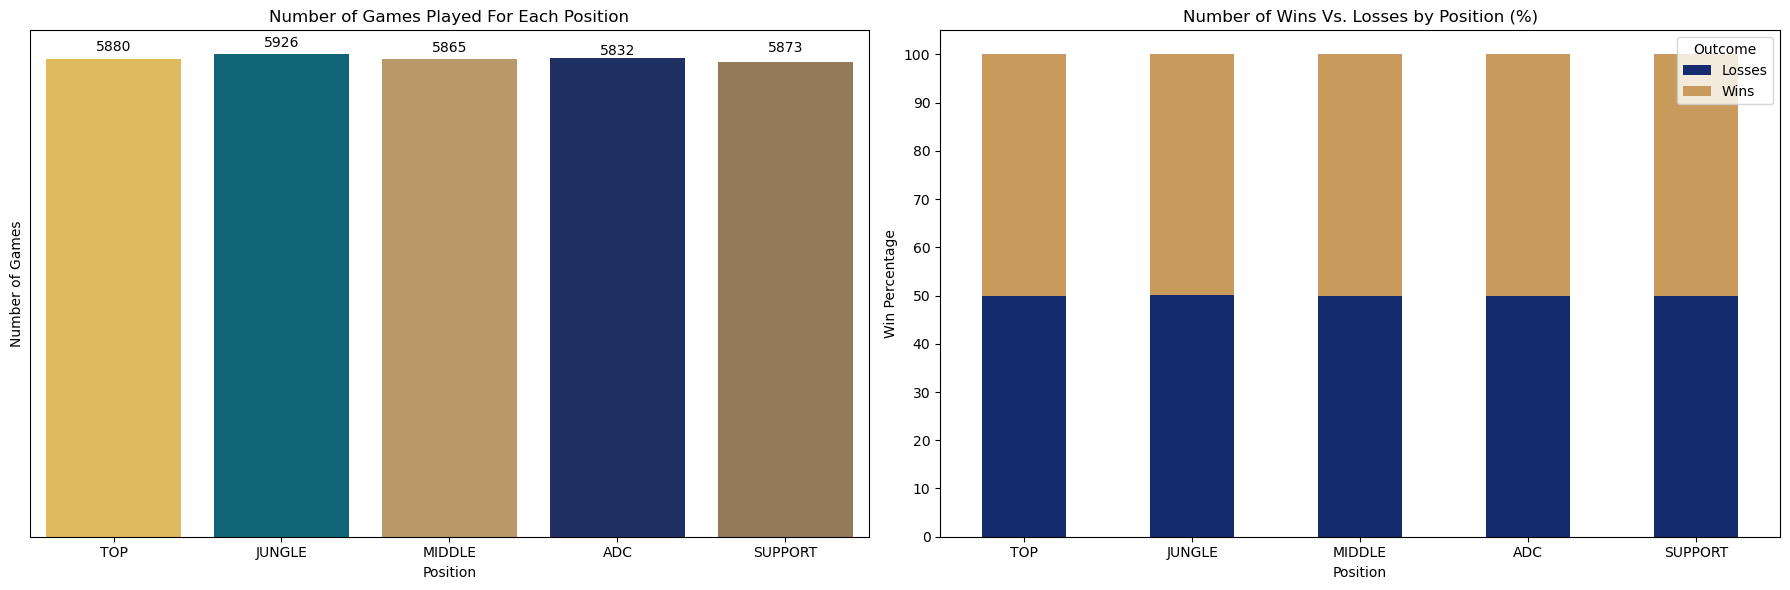

In [111]:
# defining order to display roles in
position_order = ['TOP', 'JUNGLE', 'MIDDLE', 'ADC', 'SUPPORT']

# counting wins and losses for each role, with separate columns for each count
position_wins = sr_clean.groupby(['individual_position', 'win']).size().unstack()
# converting win/loss counts to percentages
position_wins_percent = round(position_wins.div(position_wins.sum(axis=1), axis=0) * 100, 2)
# ordering rows based on position order
position_wins_percent = position_wins_percent.reindex(position_order)

# counting number of rows for each role
roles = sr_clean.groupby("individual_position").size().reset_index(name="count")


# creating two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# defining league of legends suited colour palette
league_palette = sns.color_palette(["#142b6e", "#006f87", "#c89b5d", "#9e7b4f", "#f4c249"])

# setting the custom palette
sns.set_palette(league_palette)


# plotting left bar graph: number of games for each role
sns.barplot(data=roles, x='individual_position', y='count', palette = league_palette, order = position_order,
            hue = 'individual_position', ax=axes[0])
# adding left graph title and labels
axes[0].set_title("Number of Games Played For Each Position")
axes[0].set_xlabel("Position")
axes[0].set_ylabel("Number of Games")
axes[0].set_yticks([])  # Hide y-ticks
# adding value labels for each bar
for index, row in roles.iterrows():
    axes[0].text(x=index, y=row['count'] + 50, s=row['count'], ha='center', va='bottom', fontsize=10)

# defining smaller colour palette for stacked bars
league_colors = ["#142b6e", "#c89b5d"]

# plotting right stacked bar chart: win probability by position
position_wins_percent.plot(kind='bar', stacked=True, ax=axes[1], color = league_colors)
# adding right graph title and labels
axes[1].set_title("Number of Wins Vs. Losses by Position (%)")
axes[1].set_xlabel("Position")
axes[1].set_ylabel("Win Percentage")
axes[1].legend(["Losses", "Wins"], title="Outcome") # adding a legend
# adjusting x and y ticks
axes[1].tick_params(axis='x', rotation=0)
axes[1].set_yticks(range(0, 101, 10))

plt.tight_layout()
plt.show()

Based on the left graph, the dataset appears to be very well balanced, with each role being represented by roughly the same amount of rows. This is promising as it gives the classifier enough information to learn trends for each role. 

Interestingly, the right graph shows that each role has an almost perfect 50% win rate! This means the dataset is very well balanced and the classifier should not fall into the trap of just predicting a win (or loss) if a player plays a specific role because no role has a very high win rate. Another comment that can be made about this information is that the League of Legends developers have indeed managed to create a system whereby no role seemingly has an advantage over the other in terms of win rate.

It must be noted, however, that this win rate is calculated over all game versions. This means that, while over time win rates are balanced, on a specific game version some roles may still have a much higher win rate than others. To check this, I will visualize the win rates of two positions that are known to be more volatile in terms of win rates from experience- Jungle and Support- over all the game versions available in the data set.

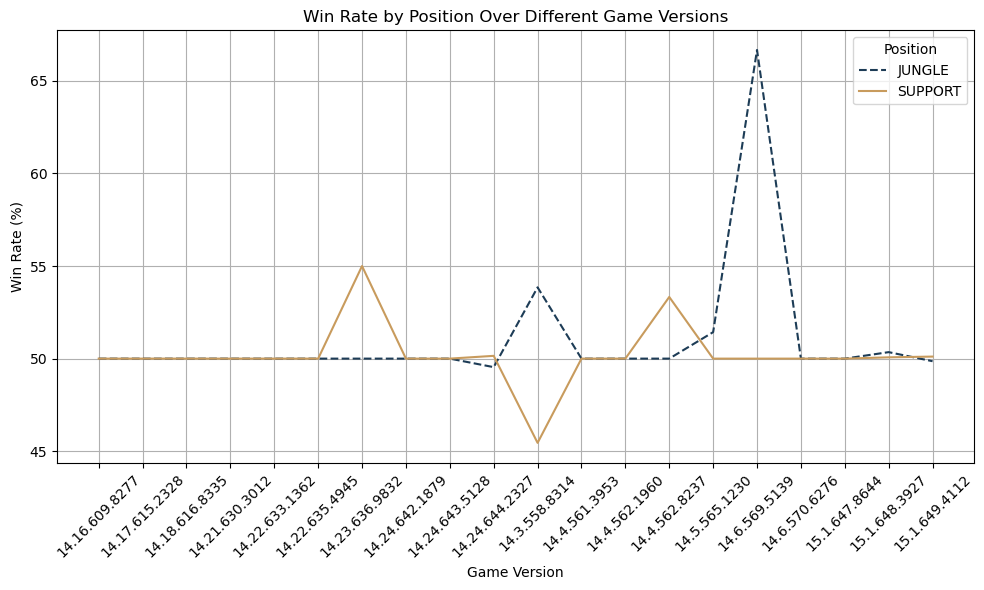

In [114]:
# counting wins and losses for each position for each game version, with separate columns for each count
ver_position_wins = sr_clean.groupby(['game_version', 'individual_position', 'win']).size().unstack()
# converting counts to percentages
ver_position_wins_percent = round(ver_position_wins.div(ver_position_wins.sum(axis=1), axis=0) * 100, 2)

# dropping the loss rates
ver_position_wins_percent = ver_position_wins_percent['TRUE']

# reordering based on position order
ver_position_wins_percent = ver_position_wins_percent.reindex(position_order, level='individual_position')
# making each role a column showing the win rate
ver_position_wins_percent = ver_position_wins_percent.unstack(level='individual_position')

# plotting line graphs for jungle and support only on the same plot
plt.figure(figsize=(10, 6))

plt.plot(ver_position_wins_percent.index, ver_position_wins_percent['JUNGLE'], label= 'JUNGLE',
         color = '#1d3c56', linestyle = '--')
plt.plot(ver_position_wins_percent.index, ver_position_wins_percent['SUPPORT'], label= 'SUPPORT', color = '#c89b5d')

# adding title, labels and legend
plt.title('Win Rate by Position Over Different Game Versions')
plt.xlabel('Game Version')
plt.ylabel('Win Rate (%)')
plt.legend(title='Position')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

As I theorised, on some game versions, these positions have varying win rates. Most notably, on game version 14.5, Jungle had a win rate over 65%, which is quite significantly higher than its win rate on any other game version. On the contrary, Support had a poor win rate of around 45% on the last version of patch 14.24. Despite these notable results, most of the time the win rates are stagnant at 50%, and as we can see with the Support win rates, some versions with higher than 50% win rates are cancelled out by versions with lower than 50% win rates. This shows that while it may be difficult to balance win rates on any given specific patch, developers ensure that win rates average close to 50% over time.

Other than win rate, it would be interesting to see how other performance metrics differ (or not) by roles. A very important and widely used indicator for performance used by players is the amount of eliminations, deaths and assists, so we can visualize the distribution of these metrics by role using boxplots as is done below. Before viewing the results, I expect to see positions such as ADC and Middle having a higher amount of eliminations, with Supports having more assists. As for deaths, since players in the Top and Support role typically play frontline and try to protect their damage dealers, I would not be surprised with them having higher deaths.

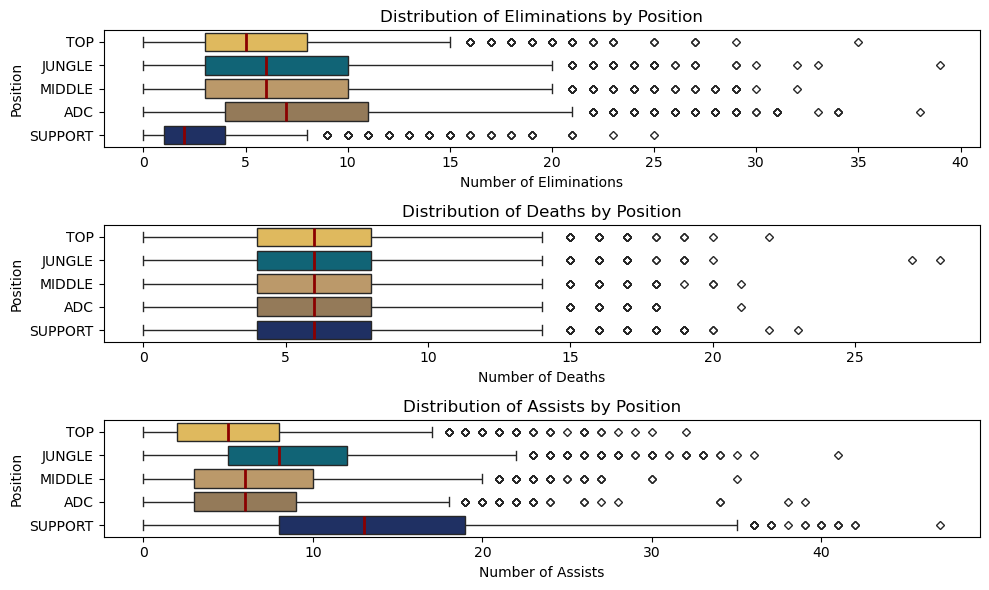

In [118]:
# Creating boxplots for eliminations, deaths, and assists by position
plt.figure(figsize=(10, 6))

# adjusting outlier symbols
flierprops = dict(marker = 'D', markersize = 4)


# creating 3 horizontal subplots
plt.subplot(3, 1, 1)

# plotting eliminations boxplot horizontally
sns.boxplot(x = 'eliminations', y = 'individual_position', data = sr_clean, palette = league_palette, 
            hue = 'individual_position', flierprops = flierprops, medianprops=dict(color='#8B0000', linewidth=2), order = position_order)
plt.title('Distribution of Eliminations by Position')
plt.xlabel('Number of Eliminations')
plt.ylabel('Position')


# plotting deaths boxplot horizontally
plt.subplot(3, 1, 2)
sns.boxplot(x = 'deaths', y = 'individual_position', data = sr_clean, palette = league_palette, 
            hue = 'individual_position', flierprops = flierprops, medianprops=dict(color='#8B0000', linewidth=2), order = position_order)
plt.title('Distribution of Deaths by Position')
plt.xlabel('Number of Deaths')
plt.ylabel('Position')


# plotting assists boxplot horizontally
plt.subplot(3, 1, 3)
sns.boxplot(x = 'assists', y = 'individual_position', data = sr_clean, palette = league_palette, 
            hue = 'individual_position', flierprops = flierprops, medianprops=dict(color='#8B0000', linewidth=2), order = position_order)
plt.title('Distribution of Assists by Position')
plt.xlabel('Number of Assists')
plt.ylabel('Position')

plt.tight_layout()
plt.show()

For the most part, I was quite spot on about my predictions for how the metrics would be distributed. Players who play ADC generally have higher eliminations, averaging around 7 eliminations a game, with Middle and Jungle following closely with an average around 6. These three roles also have similar interquartile ranges, unlike Support and Top which have a much smaller usual range of eliminations per match. Support having the lowest average and lowest maximum amount of eliminations is also very understandable, given their more utility based role.

Likewise, the amount of assists is also as expected, with support clearly having a higher average than the rest of the roles, the highest value overall and the largest spread of values. On the other hand, Top seems to generally have the least amount of assists, which makes a lot of sense since the role is known for mainly fighting against a single opponent- the enemy Toplaner- for majority of the game (for players who understand, this could provide evidence that Top lane truly is an island!).

The most surprising result is the distribution of player deaths. No matter what role a person plays, it seems they have an almost identical distribution of deaths in terms of average, interquartile range and outlier bounds. This contradicts the idea that Top laners and Support players have more deaths to protect the team- turns out a damage dealer is generally just as likely to die the same amount of times as a frontline player on average.

#### **e) Game Duration Analysis**

The length of a game can have an effect on the performance of players due to the mental and physical fatigue they face that can cause lapses in concentration, makeing players prone to playing worse. One way we can inspect whether there are any patterns involving the performance of players depending on the game duration is to plot a scatter plot between the two. To keep this section brief, we will use the `kda` column we created earlier that summarises performance metrics we used in the previous plot and the `gold/min` column since using `gold_earned` would not give us much insight as it always increases over time, while the average gold per unit time may vary differently.

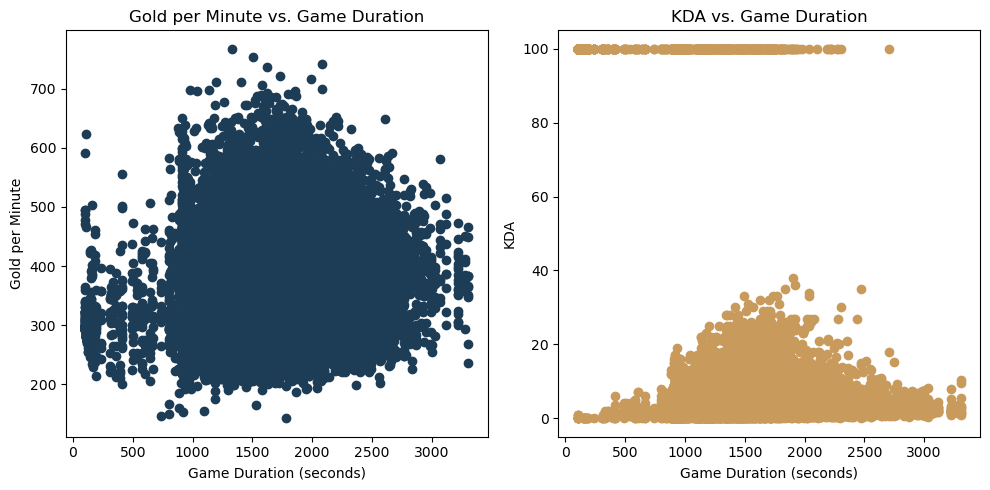

In [123]:
# creating 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# plotting left scatter plot for gold/min against duration
axes[0].scatter(sr_clean['game_duration'], sr_clean['gold/min'], color='#1d3c56')
axes[0].set_xlabel('Game Duration (seconds)')
axes[0].set_ylabel('Gold per Minute')
axes[0].set_title('Gold per Minute vs. Game Duration')


# plotting right scatter plot for kda against duration
axes[1].scatter(sr_clean['game_duration'], sr_clean['kda'], color='#c89b5d')
axes[1].set_xlabel('Game Duration (seconds)')
axes[1].set_ylabel('KDA')
axes[1].set_title('KDA vs. Game Duration')

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

From both graphs it is quite evident that neither performance metric has a linear relationship with game duration. Focusing on gold per minute, for games of any length, there seems to be players with a high, medium and low gold per minute, or in other words, the gold earned per minute for a player stays constant regardless of how long a game is. It can be noted, however, that medium lengthed games observe the highest gold per minute while players in very long games have a relatively lower gold per minute. This could mildly suggest player performance is optimised when a game is not too long, while longer games see player performances dip slightly. Nonetheless, for the most part, players are able to keep a pretty consistent gold earned per minute regardless of game duration.

The story is different for KDA; ignoring the values at the top, it can quite clearly be seen that KDA is low in matches that are short, possibly because players do not have enough time to pick up eliminations or assists, but when it comes to matches of medium length duration, the KDA of players mostly improves quite significantly, as players gain more eliminations over time. Finally, when we look at matches that are long, we start to see a dip in the KDA, suggesting that players playing for longer periods start to experience more deaths compared to the eliminations or assists they obtain. This pattern is the same as the one explained for gold per minute, but it is much more pronounced and gives much more evidence in support that player performance peaks when a game is not too long, and starts to decline as players start to fatigue and play worse as the game goes on for longer.

Examining the KDA values of 100 in the right graph, which represent a perfect KDA, there seems to be a relatively consistent amount of players acheiving a perfect KDA for games that are under 2000 seconds (\~33 minutes) long but there are no players who achieve a perfect KDA when a game goes longer than 2800 seconds (\~46 minutes). This further backs up my claim of player performance dipping as a game goes on for too long. 

#### **f) Performance Analysis Based on Solo Rank**

The last visualisation I would like to create before we fit the classifier model is to show the difference in player performance based on their solo rank tier. Naturally, one would expect a Challenger player to perform better than a player in Iron, but it would be interesting to see just how big the gap is. Like the previous plots, we will use similar performance metrics, with the addition of `total_damage_dealt` and `vision_score`. The results will be displayed using a heatmap similar to the correlation map we used earlier, and the metrics will be scaled using a standardisation scaler in order to make all performance metrics easily comparable.

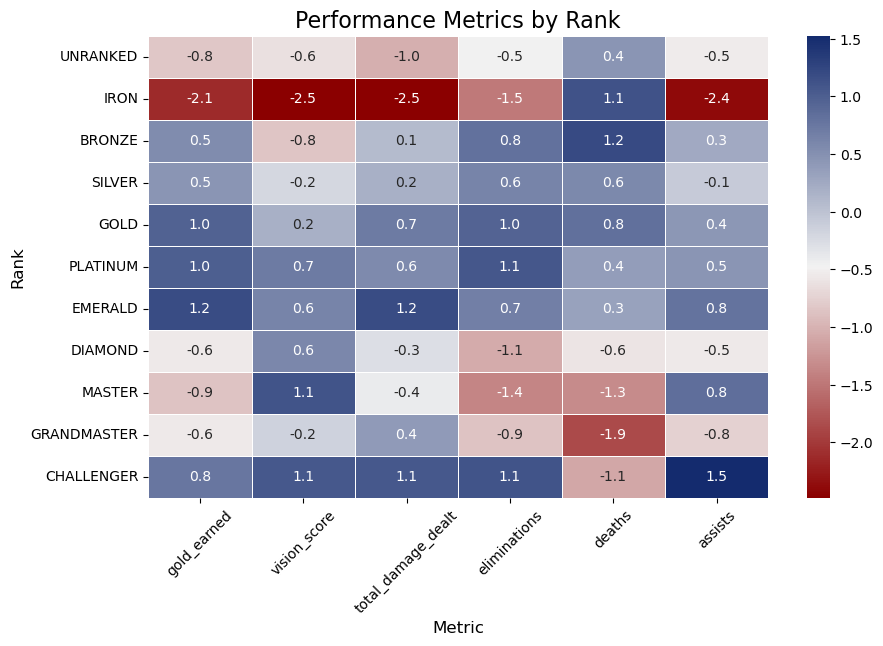

In [128]:
# calculating average performance metrics for each rank
ranks = sr_clean.groupby('solo_tier')[['gold_earned', 'vision_score', 'total_damage_dealt', 'eliminations', 
                                       'deaths', 'assists']].mean()
# displaying rank in correct order
rank_order = ['UNRANKED', 'IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'EMERALD',
              'DIAMOND', 'MASTER', 'GRANDMASTER', 'CHALLENGER']
ranks = ranks.reindex(rank_order)

# standardising metrics
scaler = StandardScaler()
ranks_standardized = pd.DataFrame(scaler.fit_transform(ranks), columns=ranks.columns, index=ranks.index)

# plotting heatmap
plt.figure(figsize=(10, 6)) 
sns.heatmap(ranks_standardized, annot=True, fmt=".1f", cmap=league_c_scale, linewidths=0.5)

# customising title and labels
plt.title('Performance Metrics by Rank', fontsize=16)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Rank', fontsize=12)
plt.xticks(rotation = 45)

plt.show()

In the above graph, values with a deep red colour show a value that is very low compared to the rest while a dark blue colour signifies a value that is much higher than other values for that feature. For every performance measure except deaths, which signifies a good performance if low, we expect to see good performances represented by dark blue colours.

In general, players in higher ranks outperform players in lower ranks in basically all performance metrics. Specifically comparing the highest rank, Challenger, and lowest rank, Iron, both ranks are completely on the opposite ends of the scale. For example, a Challenger player on average has the highest amount of assists and some of the highest gold earned, vision etc. while also having one of the lowest average deaths. In contrast, an Iron player has the worst average for every metric except deaths, for which it has the second highest average deaths.

While this trend is mostly followed by the other ranks, there are some interesting observations about this information. Although Master players are some of the highest ranked players, they observe some of the lowest average gold earned. Similarly, players between the ranks of Diamond and Grandmaster have some of the lowest average eliminations. Coupled with the low amount of deaths, this could potentially suggest that there is less fighting involved in matches at these ranks.

Out of all the performance metrics, one I find particularly interesting is the vision score. It is a known fact among players that vision is one of the most important aspects of the game and the key to winning matches as it involves gaining the ability to see what the enemy is doing while simultaneously preventing them from seeing your team, and it is known that players in lower ranks tend to ignore this task while players in higher ranks prioritise it. With the exception of Grandmaster, this is perfectly portrayed by the visualisation as players in low ranks seem to not value warding while players in high ranks do.

## **Match Outcome Classifier Model**

#### **a) Fitting the Model**

After analysing the data and obtaining good insights into player performance trends, I will now train a machine learning model to predict the outcome of a game based on a player's performance, along with calculating the probability that a player wins a game. I decided to use a CatBoost (Categorical Boosting) classifier model due to the amount of features with many different categories in the dataset, particularly the champion name column which has over 150 characters. Since this model is built to support features with categorical data, I believe it is better suited over models such as Random Forests, which would require a type of encoding to be done to the categorical columns before it can use the data.

A CatBoost model employs a technique called gradient boosting, whereby the model starts off by creating a decision tree (a series of yes or no questions that leads to a prediction being made) to make predictions, often times with a high loss, then makes a new decision tree that improves upon the previous, and so on, creating more improved trees until a prediction that minimizes the loss function is made by combining the results of the trees.

Before fitting the model, we need to define the independent and dependent variables. All of the features will be used as independent variables except:

1. the `win` column, since it is the dependent variable,
2. the game and summoner ID columns as they are only for identification purposes,
3. the day and year columns since there are only two years of data and the day of the month likely won't help predictions much compared to what day of the week or the time of day which are already included in the model,
4. `kda` and `gold/min` because they are derived from columns already in the model and would just increase the model complexity more than actually improving the fit,
5. `game_mode` since all of the data is about the Classic mode anyway.

We will also split the data into a training and test set, with 80% of the data being used to train and 20% being used to test the performance of the model.

In [134]:
# defining independent variables
X = sr_clean.drop(columns=['win', 'game_id', 'summoner_id', 'day', 'year', 'kda', 'gold/min', 'game_mode'])  # Replace 'target' with your actual target column
# defining dependent variable
y = sr_clean['win']
# splitting into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

The CatBoost model has a unique data type that works well with it called a 'pool', so I will convert the X and y variables into pools.

In [137]:
# defining the categorical columns that the model needs to deal with
cat_columns = ['game_version', 'champion_name', 'individual_position', 'solo_tier',
               'solo_rank', 'is_weekend', 'month', 'day_of_week']
# creating a train and test pool
train_pool = Pool(X_train, label = y_train, cat_features=cat_columns)
test_pool = Pool(X_test, label = y_test, cat_features=cat_columns)

Now that we have the data ready for the model to fit, we need to make sure that we set good hyperparameters for the model. Unfortunately, I do not have the time or computational resources to automatically tune hyperparameters using a grid search or randomised search cross validation, but from manual experimenting I found some hyperparameter values that produce quite good results and is sufficient for the scale of this project. These hyperparameters are listed below in the code block.

In [139]:
# defining hyperparameters for the model
params = {
    'iterations': 500,  # how many trees are built (boosting rounds)
    'depth': 10,         # depth (complexity) of trees
    'learning_rate': 0.1,  # step size for updating model weights
    'loss_function': 'Logloss',  # binary classification loss function
    'custom_metric': ['AUC', 'Accuracy', 'Logloss'], # evaluation metrics
    'verbose': False,  # hide training output
    'random_seed': 100 # ensure same results each run
}

# initializing model with hyperparameters
model = CatBoostClassifier(**params)
# fitting model with the training pool and evaluating out of sample performance with test pool
# adding early stopping if model fit is not improving
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

Our classifier has been created successfully! 

#### **b) Evaluating the Model**

The next step is to test how well this classifier actually performs. This is where the portion of data that we kept for testing comes in; we can use the model to predict the match outcomes for each row based on the independent variables then compare the prediction with the actual outcome. With the CatBoost model, this step is done when fitting the model so to obtain the performance metrics we simply just need to access these results.

In [144]:
# getting the relevant evaluation metrics
model_metrics = model.eval_metrics(test_pool, ['AUC', 'Logloss', 'Accuracy'])

# obtaining the best value for each metric
max_auc = max(model_metrics['AUC'])
max_accuracy = max(model_metrics['Accuracy'])
min_logloss = min(model_metrics['Logloss'])

# creating table with metrics and labels
performance_measures = [["Area Under The ROC Curve (%)", round(max_auc * 100, 2)],
                        ["Accuracy (%)", round(max_accuracy * 100, 2)],
                        ["Logloss", round(min_logloss, 2)]]
# defining headings
headings = ["Metric", "Value"]

# displaying table neatly
performance_table = tabulate(performance_measures, headings, tablefmt="simple_grid")
print(performance_table)

┌──────────────────────────────┬─────────┐
│ Metric                       │   Value │
├──────────────────────────────┼─────────┤
│ Area Under The ROC Curve (%) │   95.36 │
├──────────────────────────────┼─────────┤
│ Accuracy (%)                 │   88.39 │
├──────────────────────────────┼─────────┤
│ Logloss                      │    0.27 │
└──────────────────────────────┴─────────┘


Based on the results in the table, my model seems to have fit the data quite well. Let us analyse each metric individually:

1. Area under the ROC (Receiver Operating Characteristic) curve- which is a graphical representation of the classifier's performance in simple terms- shows the probability of the classifier ranking a positive value (a win) higher than a negative value (a loss). In other words, on a scale from 0 to 1 it shows the ability of the classifier to distinguish between two classes. Seeing that the model achieved a 95% AUC score means the model is able to give an actual win a higher win probability than a loss 95% of the time, which is very good. 

2. Accuracy simply shows the amount of match outcomes that the model correctly predicted when comparing to the actual match outcome. Our 88% accuracy shows that the model predicts the match outcome very well, especially considering that the amount of wins and losses are balanced so the model could not achieve a good accuracy by just classifying all values as only wins or only losses.

3. Logloss shows how close the predicted probability is to the actual value. Consider three scenarios for a match that was actually won: if it is predicted to be a win with, say a 99% win probability, the logloss will be very low; if it is predicted to be a loss with a 1% chance of winning, the logloss will be very high, and if it is predicted to be a loss with a 49% win probability, the logloss will be somewhere in between. The important thing to note is that the logloss punishes 'confident' wrong classifications and 'uncofident' correct classifications more severely. A value of 0.27 is quite promising, since it is much lower than the rule of thumb score of 0.693, which represents a model that just guesses at random, but it is signifying the model performance is not as good as the other two metrics suggest. One possible reason for the slighlty elevated logloss is that, while the model mostly predicts correctly based on the other two metrics, when the model makes a misclassification, it is confident in that misclassification.

Overall, looking at all three performance indicators together, the model performs very well on unseen data and will be useful for players to predict the win probability of a match based on their individual performance.

As a check for the robustness of our model, I will also perform cross validation of the model to obtain more solid values for the performance metrics that are not as reliant on the data being split well.

In [147]:
# performing cross-validation
cv_results = cv(
    params = params,
    pool = train_pool,
    fold_count = 5,  # number of folds
    stratified = True,  # stratified sampling
    partition_random_seed = 100, # ensure results are replicated
    shuffle = True, # allow the sample to be shuffled
    verbose = 0 # hide output information
)

Training on fold [0/5]

bestTest = 0.2648944225
bestIteration = 301

Training on fold [1/5]

bestTest = 0.2808109123
bestIteration = 322

Training on fold [2/5]

bestTest = 0.2969864479
bestIteration = 317

Training on fold [3/5]

bestTest = 0.2814624585
bestIteration = 328

Training on fold [4/5]

bestTest = 0.2891107212
bestIteration = 253



After conducting the cross validation, we can now extract the model performance indicators.

In [149]:
# getting the best cv evaluation metrics
cv_max_auc = max(cv_results['test-AUC-mean'])
cv_max_accuracy = max(cv_results['test-Accuracy-mean'])
cv_min_logloss = min(cv_results['test-Logloss-mean'])

# creating table with metrics and labels
cv_performance_measures = [["Area Under The Curve (%)", round(cv_max_auc * 100, 2)],
                           ["Accuracy (%)", round(cv_max_accuracy * 100, 2)],
                           ["Logloss", round(cv_min_logloss, 2)]]
# defining headings
headings = ["Metric", "Value"]

# displaying table neatly
cv_performance_table = tabulate(cv_performance_measures, headings, tablefmt="simple_grid")
print(cv_performance_table)

┌──────────────────────────┬─────────┐
│ Metric                   │   Value │
├──────────────────────────┼─────────┤
│ Area Under The Curve (%) │   95.19 │
├──────────────────────────┼─────────┤
│ Accuracy (%)             │   87.87 │
├──────────────────────────┼─────────┤
│ Logloss                  │    0.28 │
└──────────────────────────┴─────────┘


The results we obtained from cross validation are very close to the out of sample results we obtained from using the train-test split, so we can conclude that the performance of the model is robust.

#### **c) Analysing Most Important Features For Classifying Match Outcome**

The last task of this project is to examine which features contribute the most to predicting match outcomes. At the start of this notebook, I mentioned that gold earned, number of eliminations and the rank of the player are the features I expect to be the most important, so it will be interesting to find out what actually pushes win probability the most. An easy way to check this is by visualising it with the Shapley Additive Explanations library, which calculates SHAP values that show how each feature contributes to a prediction.

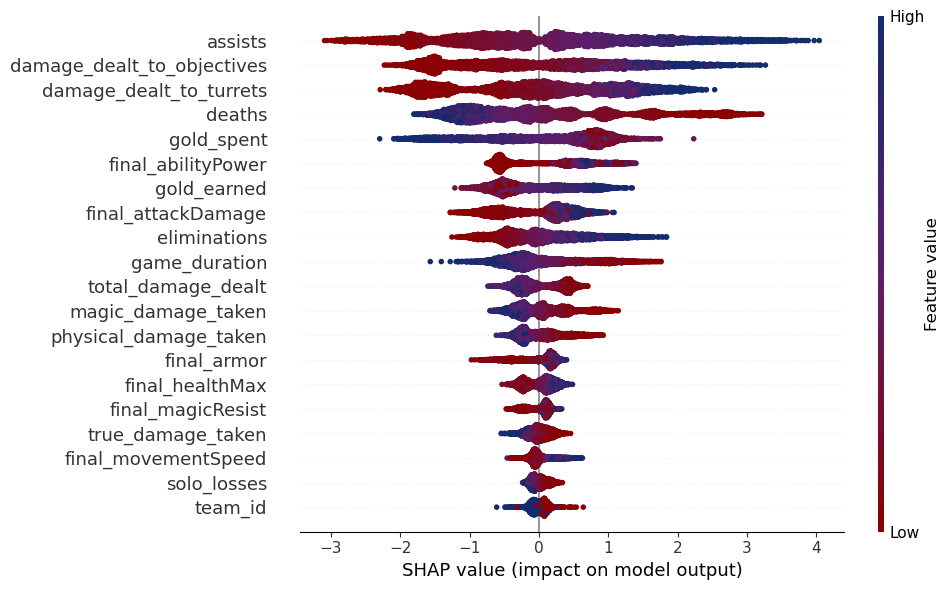

In [153]:
# creating new colour scale better suited for plot
league_cmap_colors2 = ["#8B0000", "#5D1F6B", "#142b6e"]
league_c_scale2 = LinearSegmentedColormap.from_list("league_c_scale2", league_cmap_colors2, N=256)

# creating explainer object
explainer = shap.TreeExplainer(model)
# calculating shap values
shap_values = explainer.shap_values(X_test)

# plotting summary plot to show feature importance
shap.summary_plot(shap_values, X_test, cmap = league_c_scale2, plot_size=(10, 6))


The graph above displays the top 20 most influential features for predicting match outcome, ranked in descending order of mean absolute SHAP value. The x-axis represents the SHAP values of each feature, which simply show whether a feature's value pushed the win probability higher, if positive, or lower if negative. The dots that form bars in line with each feature name represent each point in the data, with their colour representing the size of the value. For example, looking at damage dealt to objectives, blue values have a high positive SHAP value, while red values have mostly negative SHAP values. This suggests that players increase their chance of winning when they deal more damage to objectives and likewise reduce their chance of winning if they deal less objective damage. Some key observations from the graph are discussed below:

Interestingly, while gold earned and eliminations are among the top 10 most important features, the most important feature by quite a large margin is the amount of assists! One possible reason that assists are more important to predict win probability than eliminations is that it reflects team coordination better. Since League of Legends is a team based game, the ability of a team to work together oftentimes is more important than individual performances. Having more assists reflects more team fighting as opposed to solo fighting, which suggests players with more assists may win more games since they are playing with the team more. Conversely, another feature that is more influential on predictions than eliminations or gold earned, deaths, suggests having more deaths reduces a player's chances of winning while having less deaths increases it.

Looking at the second and third most important features, it makes sense why higher values for these features improve win probability- or low values decrease win probability- more than others. Dealing damage to objectives and turrets are important ways to gain advantages in the game, by allowing players to earn more gold- to buy items- and taking more control over the map. The fact that these features ranked much higher than the columns representing damage dealt to champions possibly signifies that fighting for objectives in the game is more important to win games than fighting for eliminations.

Furthermore, contrary to my expectation of solo rank being an important feature for predictions, it did not even make the top 20. Instead, features like `team_id` were more important. On first glance, it may not make sense that this ID column is useful for predictions, but this column, which takes one of two values, 100 or 200, represents whether a player is playing on the blue side of the map (the bottom left) or the red side of the map (top right) respectively. Other than access to certain objectives and visibility difference from playing down-up or top-down, the difference in sides also determines the order in which champions are picked or banned. Historically, it is known by players that blue side tends to have an advantage, and seeing that the lower `team_id` values (which represent blue side) increase win probability while the higher values (indicating red side) decrease win probability may suggest that this claim is actually true!

Lastly, although `champion_name` was not among the top 20 most important features, it is still interesting to check which champions are most influential on win probability. To check this, I will display the top 10 champions that contribute the most to improving win probability and the top 10 champions that contribute the most to decreasing win probability with bar charts.

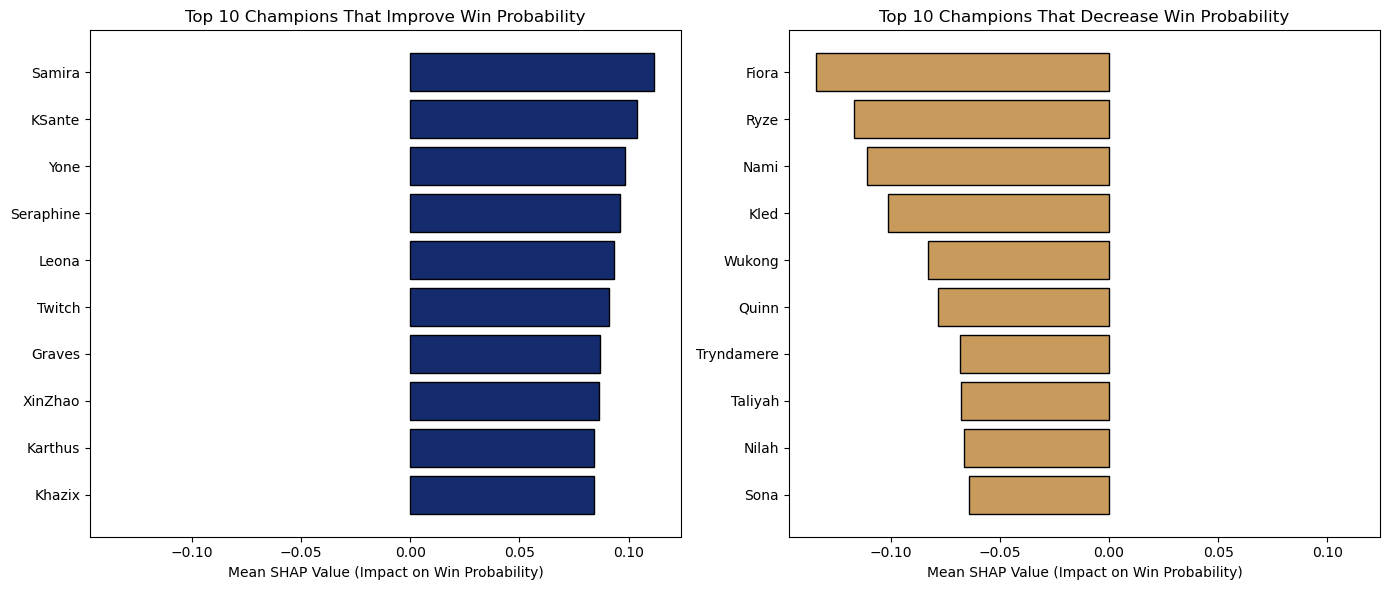

In [157]:
# obtaining shap values for champions
champion_shap = pd.DataFrame({
    "Champion": X_test['champion_name'],
    "abs_shap": shap_values[:, X_test.columns.get_loc('champion_name')]
})

# calculating mean shap value for each champion sorted from largest to smallest
champion_importance = champion_shap.groupby("Champion")["abs_shap"].mean().sort_values(ascending=False)

# getting top 10 champions that increase and decrease win probability
top_increase = champion_importance.head(10)
top_decrease = champion_importance.tail(10)  

# creating subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# champions that increase win probability
axes[0].barh(top_increase.index[::-1], top_increase.values[::-1], color='#142b6e', edgecolor='black')
axes[0].set_title("Top 10 Champions That Improve Win Probability")
axes[0].set_xlabel("Mean SHAP Value (Impact on Win Probability)")

# champions that decrease win probability
axes[1].barh(top_decrease.index, top_decrease.values, color='#c89b5d', edgecolor='black')
axes[1].set_title("Top 10 Champions That Decrease Win Probability")
axes[1].set_xlabel("Mean SHAP Value (Impact on Win Probability)")

plt.tight_layout()
plt.show()

Although the magnitude of the SHAP values are not as high as the SHAP values we saw for the most important columns, there are still some interesting trends to be seen in these graphs. 

Firstly, Samira being the champion that positively influences win probability the most is actually quite understandable since she is a character that is relatively simple to play and is known for being one of the easiest champion to get penta-kills (eliminating all enemy players in a short amount of time) with. Other champions like Yone, Seraphine, Twitch and Karthus are very good scaling champions that have relatively easier mechanics, and would make sense to be influential on being more likely to win a game.

Based on the second graph, the top 2 champions that decrease win probability are also notably two of the most difficult champions to master in the game. This could suggest that players are not able to fully unlock the potential of these characters, leading to them lowering win probabilities. Another trend that is seen is that a lot of the champions that decrease win probability the most are relatively obscure or less played champions. For example, Ryze, Kled and Nilah are champions that are not played as often, particularly in lower ranks where most of the player base lies, so it could be the case that teams with these champions are unable to efficiently utilise these champions' abilities, leading to them lowering their chances of winning.

An important thing to consider is that players are not evenly distributed between ranks, which is the most popular indicator of skill. Since there are more players in lower ranks than higher ranks, champions like Fiora and Ryze see worse performances more often due to the number of lower skilled players trying them out and not being able to use them correctly, which may be contributing to them being associated with lower win probabilities, while more popular, easier champions like Samira and Seraphine see higher win probabilities because most players know how to use them and teams know how to play around them.

## **Discussion of Results and Summary**

Initially, the goal of this project was to visualise League of Legends data to see player and match trends, but as I worked on this project more, it evolved into a much deeper analysis than originally planned. In this analysis, I successfully cleaned a League of Legends Match dataset, explored and analysed the features and relationships between the features to gain insights into player performance trends, as well as trained and examined a classifier model to predict the outcome of League of Legends matches with an 88% accuracy and 95% AUC score. The following points summarise the key insights that were obtained from this notebook:

1. Win rates do not differ by roles over time, even though on specific game versions some roles may have higher or lower win rates.
2. As expected, the amount of eliminations and assists that players get differ by roles, with support players having more assists on average and ADC players normally leading the elimination chart. However, the amount of deaths follows an almost identical distribution for each role, contrary to the belief that support and top lane players die more to save their team.
3. Player performance tends to peak when games are not too long, and diminishes as games take longer, seeing that player KDAs and gold per minute tend to be high for average length games and lower for very long games.
4. The performance of higher ranked players do differ quite a lot from lower ranked players, with higher ranked players outperforming them on almost every performance metric on average.
5. The most important features that contribute towards predicting a win probability are the number of assists, damage dealt to objectives and damage dealt to turrets, all of which potentially indicate better team coordination and focus on gaining advantages over the enemy team.
6. Champions that are usually easier and more accessible for lower ranked players might improve win probability more than obscure champions or champions with high skill expression.

Although these insights are very all very useful, it is also important to acknowledge potential limitations with both the data and my analysis that could have an effect on the results we obtained as well as areas for improvement:

**Limitations and Potential Areas For Improvement:**

1. All of the data related to players on the EU Nordic and East server. While not being a small server by any means, it is still not as popular as servers like Europe West, North America and Korea. As a result, the results obtained from this analysis may not be representative of the entire League of Legends player base, and may only be representative of players on this specific server.
2. Even though our predictive model ended up using a large number of predictors, there are still many more features that could have provided useful information to improve the model performance. These include the number of minions killed, which is a very important feature that was not included in the dataset, and the flexed rank columns, which were removed due to the abundance of missing data.
3. With more time and computational resources, a better model may be obtained through automated hyperparameter tuning, but given that a good model was fit with relatively little tuning, this limitation is not so severe.
4. This project only focused on the Classic Summoner's Rift mode, but there is still data on the ARAM and Swiftplay modes available, which may be useful to analyse in the future.

Despite the limitations, I am satisfied overall with the results of the analysis. I believe the information in this notebook is useful for players to determine aspects that they may need to consider to improve their performance in the game, and this analysis may also be useful to developers as they can assess trends about the game that maybe were intended or not so that they can improve the player experience.

## **Acknowledgements**

For a detailed list of libraries and resources that were used for coding, debugging and writing the content of this notebook, please see the [Acknowledgements Wiki page](https://github.com/aymaan-kj/League-of-Legends-Match-Analysis/wiki/Acknowledgements).